## Generating a Climate Change Knowledge Graph


### 1. Load Packages

In [1]:
import Config as CON
import os
import sys
import random
import json
import time
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import string
import penman
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from rapidfuzz.distance import Levenshtein
import amrlib
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize

#Declare some necessary global functions and objects
stog = amrlib.load_stog_model()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
current_time_ms = lambda: int(round(time.time() * 1000))

## 2. Read keyword frequency and identify top keywords (candidate entities)

In [2]:
'''
I have already read the corpus, and computed frequency (in how many paper it appears) of each author-provided-keyword.
'''
keyword_filename = os.path.join(CON.OUTPUT_DATA_DIRECTORY,"keyword_frequency.txt")
assert(os.path.exists(keyword_filename))

with open(keyword_filename, encoding='utf-8') as f:
    keyword_frequency = json.loads(f.read())

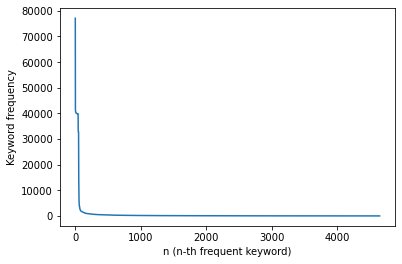

In [3]:
'''
Top keywords are the ones that cover 80% of total keyword appearances.
keyword_frequency[x] = how many times keyword x appeared in the corpus
'''
i = 0
sum_frequency = 0
freq_list = []

for key in keyword_frequency.keys():
    i +=1
    f = keyword_frequency[key]
    freq_list.append(f)
    sum_frequency += f

top_keywords = []
cumulated_frequency = 0
for key in keyword_frequency.keys():
    f = keyword_frequency[key]
    cumulated_frequency += f
    top_keywords.append(key)
    #Set it to 0.6 (60%) for a quick run
    if cumulated_frequency>(0.8*sum_frequency):
        break

'''
Try to discard repeated appearance of the same keyword in a different form
'''
top_keywords = list(set([wordnet_lemmatizer.lemmatize(k.lower()) for k in top_keywords]))

plt.plot(np.arange(0,len(top_keywords)),freq_list[0:len(top_keywords)]); #Show frequency distribution of top keywords
plt.xlabel('n (n-th frequent keyword)')
plt.ylabel('Keyword frequency')

#Write top keywords to a file
with open('top_keywords.txt', 'w') as f:
    for item in top_keywords:
        f.write("%s\n" % item)

## 3. Train a syntactic parser with ability of chunking phrases

Also define some helper functions to read the parser

In [4]:
'''
Train a phrase-chunking mode based on CONLL-2000 corpus
'''
from nltk.corpus import conll2000
from nltk.chunk.util import tree2conlltags,conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

data= conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]

def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

#Define the chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
        train_sent_tags=conll_tag_chunks(train_sentences)
        self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)
        
    def parse(self,tagged_sentence):
        if not tagged_sentence:
            return None
        pos_tags=[tag for word, tag in tagged_sentence]
        chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
        chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
        wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
        return conlltags2tree(wpc_tags)

#train chunker model
ntc=NGramTagChunker(train_data)
#evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [5]:
def print_tree(t):
    '''
    Given a parse tree t, convert it to a string for visualization
    '''
    try:
        t.label()
    except AttributeError:
        return t[0]
    else:
        txt = ""
        for child in t:
            txt = txt + print_tree(child).strip() + " "
        return txt.strip()

In [6]:
def traverse(t):
    '''
    Input:
        A syntactic parse tree, t
    Returns:
        List of noun phrases (chunked) -- are possible entities
        List of verb phrases (chunked) -- are possible relations
    '''
    noun_phrases = []
    verb_phrases = []
    try:
        t.label()
    except AttributeError:
        return ([],[])
        
    else:
        if(t.label()=='NP'):
            noun_phrases.append(print_tree(t))
            
        if(t.label()=='VP'):
            verb_phrases.append(print_tree(t))
        
        for child in t:
            np, vp = traverse(child)
            noun_phrases.extend(np)
            verb_phrases.extend(vp)
            
    return noun_phrases, verb_phrases

## 4. Helper functions to modify the triplets found

In [7]:
def convert(word, from_pos="v", to_pos="n"):    
    """ 
        Transform words given from/to POS tags.
        The assumption is, in a (subject, object, verb) triplet, subject and object should be noun-phrases
    """
    
    WN_NOUN = 'n'
    WN_VERB = 'v'
    WN_ADJECTIVE = 'a'
    WN_ADJECTIVE_SATELLITE = 's'
    WN_ADVERB = 'r'

    # If the word is already in desired form, no need to modify
    synsets = wn.synsets(word, pos=to_pos)
    if synsets:
        return word
    
    synsets = wn.synsets(word, pos=from_pos)

    # Word not found, perhaps the word is not a verb, and maybe already a noun
    if not synsets:
        return word

    # Get all lemmas of the word (consider 'a'and 's' equivalent)
    lemmas = []
    for s in synsets:
        for l in s.lemmas():
            if s.name().split('.')[1] == from_pos or from_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and s.name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                lemmas += [l]

    # Get related forms
    derivationally_related_forms = [(l, l.derivationally_related_forms()) for l in lemmas]

    # filter only the desired pos (consider 'a' and 's' equivalent)
    related_noun_lemmas = []

    for drf in derivationally_related_forms:
        for l in drf[1]:
            if l.synset().name().split('.')[1] == to_pos or to_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and l.synset().name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                related_noun_lemmas += [l]

    # Extract the words from the lemmas
    words = [l.name() for l in related_noun_lemmas]
    len_words = len(words)

    # Build the result in the form of a list containing tuples (word, probability)
    result = [(w, float(words.count(w)) / len_words) for w in set(words)]
    result.sort(key=lambda w:-w[1])
    
    #Get the noun that is closer to the word syntactically (edit distance) and matches symantically
    d = 10000
    i = 0
    res = ""
    for entry in result:
        '''
        when converting from verb to noun, insertion is natural
        entry[1] is the probability/semantic similarity, so (1-entry[1]) can be a distance
        '''
        edit_distance = (1-entry[1])*Levenshtein.distance(word,entry[0],weights=(0.5,1,1))
        if d>edit_distance:
            d = edit_distance
            res = entry[0]
        if i==3:
            break

    # return all the possibilities sorted by probability
    return res


In [8]:
#unit test
print(convert("verify"))
print(convert("attestation"))
print(convert("modify"))
print(convert("die"))
print(convert("deforest"))
print(convert("maintain"))
print(convert("water"))

verification
attestation
modification
die
deforestation
maintainer
water


In [9]:
def fix_tuple(sub,obj,rel,nps):
    '''
    Final level modification to a (subject, object, relation) tuple
    Inputs:
        (sub,obj,rel): triplet obtained from semantic parser
        nps: noun phrases obtained from a syntactic parse
        
    Outputs:
        (sub,obj,rel): remove AMR specific codecs and convert subject and object to its noun form (whenever possible)
    '''
    
    #discard AMR specific tags (cause-01 -> cause)
    if "-0" in sub:
        sub = sub[0:sub.find("-0")]

    if "-0" in obj:
        obj = obj[0:obj.find("-0")]

    if "-0" in rel:
        rel = rel[0:rel.find("-0")]
        

    sub_nps = []
    obj_nps = []
    for np in nps:
        #If subject or object matches the postfix of any of the noun phrases, that noun phrase becomes the new subject/object
        if wordnet_lemmatizer.lemmatize(np.split(" ")[-1].lower()) == wordnet_lemmatizer.lemmatize(sub.lower()):
            sub_nps.append(np)

        if wordnet_lemmatizer.lemmatize(np.split(" ")[-1].lower()) == wordnet_lemmatizer.lemmatize(obj.lower()):
            obj_nps.append(np)

    '''
    Subject and object should be nouns
    '''
    sub = convert(sub)
    obj = convert(obj)
    
    if len(sub_nps)==1:
        sub = sub_nps[0]

    if len(obj_nps)==1:
        obj = obj_nps[0]

        
    return (sub,obj,rel)

## 5. Process an abstract and generate triplets

### 5.1 Helper functions for processing sentences with AMR Semantic Parser

In [10]:
def show_entry(D, entities, src):
    '''
    Inputs:
        D: Semantic parse tree in a json (dictionary format)
        entities: variable-lexicon mapping for the parse tree entries
        src: a variable in the parse tree
        
    Output:
        string -- the appropriate lexicon for the "src" variable
    '''
    entity_base_str = entities[src]
    if "-0" in entity_base_str:
        entity_base_str = entity_base_str[0:entity_base_str.find("-0")]
        
    entity_str = ""
    
    if src in D.keys():
        #Process conjunction (and/or)
        if ((entity_base_str=="and") or (entity_base_str=="or")):
            options = [op for op in D[src].keys() if ":op" in op]
            
            if len(options)!=0:
                entity_str = show_entry(D,entities,D[src][options[0]])
                for op in options[1:]:
                    entity_str+=" "+entity_base_str+" "
                    entity_str+=convert(show_entry(D,entities,D[src][op]))
                    
        elif (entity_base_str=="name"):
            options = [op for op in D[src].keys() if ":op" in op]
            
            if len(options)!=0:
                entity_str = show_entry(D,entities,D[src][options[0]])
                for op in options[1:]:
                    entity_str+=" "
                    entity_str+=show_entry(D,entities,D[src][op])    
                
            
        #Process :mod relation
        elif ":mod" in D[src].keys():  
            entity_str = convert(entity_base_str)
            if D[src][":mod"] in D.keys() and ":mod" in D[D[src][":mod"]].keys():
                entity_str =entities[D[D[src][":mod"]][":mod"]]+" "+entity_str
            else:
                entity_str = entities[D[src][":mod"]]+" "+entity_str
    
        else:
            entity_str = convert(entity_base_str)
    else:
        entity_str = convert(entity_base_str)
    #entity_str += entities[src]
    #print(entity_base_str, entity_str)
    #print(entity_base_str)
    return entity_str

In [11]:
def amr_entailment(g, e1, e2):
    '''
            *****
            Note: Ended up not using it. 
            So this is not fine-tuned, and may not be consistent with the rest of the code.
            AMR parser does not do a great job on complex, academic text to check whether it entains a triplet.
            *****
    
    inputs:
        - g: AMR graph
        - e1: entity 1
        - e2: entity 2
        
    outputs:
        - enails: Check whether the AMR graph has a node with e1 and e2 as arguments.
        - triplets: (subject, object, relation); The node instance (relation) that has e1 and e2 as arguments
    '''
    triplets = []
    
    entities = {}
    gg = penman.decode(g)
    rels = []
    
    #Map the variables to their corresponding lexicons
    for (src, role, target) in gg.instances():
        entities[src] = target
    
    #Find a node that relates to the input subject (e1)
    for (src, role, target) in gg.edges():
        t = entities[target]
        #AMR adds additional numbers to represent a lexicon uniquely (e.g., burn -> burn-01). 
        #Remove this to get to the root form
        if "-0" in t:
            t = t[0:t.find("-0")]
            
        t = wordnet_lemmatizer.lemmatize(t.lower())
        
        #e1 is an argument of the relational verb (src)
        if t==e1 and role in [":ARG0",":ARG1"]:
            rels.append((src,role))
    
    #No candidate relational verb found
    if len(rels)==0:
        return (False, triplets)

    #For each candidate relational verb, verify that e2 is also its argument
    for (rel_src,rel_role) in rels:
        for (src, role, target) in gg.edges():

            #if e1 is arg1, then e2 should be arg2, and likewise if e1 is arg2
            des_role = ":ARG0"
            if rel_role==":ARG0":
                des_role = ":ARG1"

            #reduce target lexicon to its root form
            t = entities[target]
            if "-0" in t:
                t = t[0:t.find("-0")]
                
            t = wordnet_lemmatizer.lemmatize(t.lower())

            #verify that e2 is another argument for the relational verb
            if (src==rel_src) and (role==des_role) and (t==e2):
                src_str = entities[src]
                if "-0" in src_str:
                    src_str = src_str[0:src_str.find("-0")]

                #and is typically not a relation, rather shows that two arguments are probably related
                if src_str=="and":
                    src_str = "are related"

                if des_role==":ARG0":
                    triplets.append((e2, e1, src_str))
                else:
                    triplets.append((e1, e2, src_str))
    
    #If no triplet found, AMR fails to find any relation between e1 and e2
    if len(triplets)==0:
        return (False, triplets)
    
    #Otherwise return the triplets
    return (True, triplets)

In [12]:
def amr_triplets(g, nps):
    '''
    inputs:
        - g: AMR graph
        - nps: a list of noun phrases (extracted using a syntactic parser)
    outputs:
        - triplets (subject, object, relation)
    '''
    
    triplets = []
    entities = {}
    gg = penman.decode(g)
    
    #Map the variables to their corresponding lexicons
    for (src, role, target) in gg.instances():
        entities[src] = target
        
    D = {}
    #Find a node that relates to the input subject (e1)
    for (src, role, target) in gg.edges():
        if src in D.keys():
            D[src][role] = target
        else:
            D[src] = {}
            D[src][role] = target
    
    #print(g)
    #print(entities)
    #print(D)
    
           
    for src in D.keys():
        
        '''
        :name
        process specification
        '''
        src_alias = None
        if ":name" in D[src].keys():
            src_alias = D[src][":name"]
        '''
        Process ARG semantic type
        ''' 
        if ":ARG0" in D[src].keys() and ":ARG1" in D[src].keys():
            
            sub = show_entry(D, entities, D[src][":ARG0"])
            
            obj = show_entry(D, entities, D[src][":ARG1"])
            if src_alias is None:
                rel = entities[src]
            else:
                rel = entities[src_alias]
                        
            triplets.append(fix_tuple(sub,obj,rel,nps))
            
        #elif ":ARG1" in D[src].keys() and ":ARG2" in D[src].keys():
            
            #sub = show_entry(D, entities, D[src][":ARG1"])
            #obj = show_entry(D, entities, D[src][":ARG2"])
            #rel = show_entry(D, entities, src)
                        
            #triplets.append(fix_tuple(sub,obj,rel,nps))
        
        '''
        :ARG1-of / cause-01
        penman handles "/d :ARG1-of /c cause-01" as ":ARG0 :ARG1" pattern
        '''
        #if ":ARG1-of" in D[src].keys() and entities[D[src][":ARG1-of"]]=="cause-01":
        #    print(("*"*5)+"CAUSE role"+("*"*5))
        #    print(entities)
        #    print(D[src])
        
        '''
        :consist-of
        panman reverses any -of role in AMR. "A :consist-of B" becomes "B :consist A"
        '''
        if ":consist" in D[src].keys():
            
            sub = show_entry(D, entities, D[src][":consist"])
            
            if src_alias is None:
                obj = show_entry(D, entities, src)
            else:
                obj = show_entry(D, entities, src_alias)
            rel = "contains"
            
            triplets.append(fix_tuple(sub,obj,rel,nps))
            
        
                
    return triplets

### 5.2 Use AMR to generate triplets from the corpus

In [13]:
'''
Remove short keywords from the top keyword list
'''
temp = []
for x in top_keywords:
    #Keywords with a single or couple letters are almost meaningless
    if len(x)>=3:
        temp.append(x)
top_keywords.clear()
top_keywords = temp
top_keywords_set = set(top_keywords)

abstract_filename = os.path.join(CON.OUTPUT_DATA_DIRECTORY,"example_abstract.json")
#abstract_filename = os.path.join(CON.OUTPUT_DATA_DIRECTORY,"all_abstracts_with_keywords.json")
assert(os.path.exists(abstract_filename))

with open(abstract_filename, encoding='utf-8') as f:
    all_abstracts = json.loads(f.read())

stop_after = 300000
start_from = 0
i = start_from
graph = None
all_triplets = []

for abstract_with_keywords in all_abstracts[i:]:
    i +=1
    if (i%500 == 0):
        '''
        Write output triplets in a CSV file
        '''
        keys = all_triplets[0].keys()

        a_file = open("kb_triplets_raw_"+str(start_from)+"_"+str(i-1)+".csv", "w")
        dict_writer = csv.DictWriter(a_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(all_triplets)
        a_file.close()
    
    try:
        keywords = abstract_with_keywords["keywords"]
        abstract = abstract_with_keywords["abstract"]

        #if the paper-keywords contains some top keywords, parse it with a semantic parser.
        #else skip
        if len(set(keywords).intersection(top_keywords_set))==0:
            continue

        if abstract == "":
            continue


        sentences = sent_tokenize(abstract)
        #graphs contain AMR parse for each sentences of the abstract
        graphs = None

        j = 0

        for sentence in sentences:
            #Extract parts of speech of words and chunk them into phrases
            nltk_pos_tagged=nltk.pos_tag(sentence.split())
            chunk_tree=ntc.parse(nltk_pos_tagged)
            #print(chunk_tree)
            #Extract noun and verb phrases from the sentence
            nps, vps = traverse(chunk_tree)
            nps = list(set(nps))

            '''
            Run AMR parser on all the sentences simultaneously
            '''
            if graphs is None:
                graphs = stog.parse_sents(sent_tokenize(abstract))

            graph = graphs[j]
            #print(graph)
            triplets = amr_triplets(graph, nps)

            for item in triplets:
                (sub, obj, rel) = item
                #print("<"+sub+">, <"+obj+">, <"+rel+">")
                tr = {}
                tr["subject"] = sub
                tr["object"] = obj
                tr["relation"] = rel
                all_triplets.append(tr)

            j +=1


    except:
        print("An Exception!")
        
    print("Abstract: "+str(i))
    
    
    if i==stop_after:
        break

#Save upon completion
keys = all_triplets[0].keys()
a_file = open("kb_triplets_raw_all.csv", "w")
dict_writer = csv.DictWriter(a_file, keys)
dict_writer.writeheader()
dict_writer.writerows(all_triplets)
a_file.close()

(S
  (NP Human/JJ activities/NNS)
  (VP are/VBP increasing/VBG)
  (PP in/IN)
  (NP an/DT uncontrollable/JJ manner./NN))
(S
  (NP These/DT activities/NNS)
  (VP are/VBP causing/VBG)
  (NP climate/NN change./NN))
(S
  (NP The/DT old/JJ man/NN)
  (VP died/VBD)
  (PP of/IN)
  (NP lung/NN cancer./NN))
(S
  (NP I/PRP)
  (VP saw/VBD)
  (NP a/DT cloud/NN)
  (PP of/IN)
  (NP dust./NN))
(S
  (NP A/DT team/NN)
  (PP of/IN)
  (NP researchers/NNS)
  (VP made/VBD)
  (NP a/DT discovery/NN)
  (PP about/IN)
  (NP a/DT ring/NN)
  (PP of/IN)
  (NP gold./NN))
(S
  (NP Deforestation/NN)
  and/CC
  (NP flood/NN)
  (VP are/VBP)
  (NP bad/JJ)
  (PP for/IN)
  (NP nature./NN))
(S
  (NP Steven/NNP Spielberg/NNP)
  (VP lives/VBZ)
  (PP in/IN)
  (NP Los/NNP Angeles./NNP))
(S (NP The/DT comment/NN) (VP is/VBZ) (NP inappropriate./JJ))
Abstract: 1


## Major Limitations

1. Cannot handle negative polarity (the penman parser I used ignores the polarity edges in the original AMR graph)
2. After collecting all the triplets, we can analyze them and scrap the triplets that appears less frequently (more likely to be noise)
3. AMR is not so good with the complex sentences found in academic papers. Simplifying the sentences before using AMR might improve the quality of the triplets.
4. Summarizing a sub-parse-tree of AMR back to a sentence is challenging, and if done properly, it could make the knowledge graph way more useful. For example, rather than saying "online resources may help improvement", it might be more useful to say "online resources may help improvement of teaching evolutionary theory". In AMR parser, it is encoded as: help is the root-verb, :ARG0 being the subtree containing "resources :mod online", :ARG1 being the subtree containing the semantic aspects of "improve the teaching of evolutionary theory in European secondary schools", improvement being the root lexicon.

Note: from tuple, we can use GPT to generate simple sentences. For example, ("air pollution", "cancer", "cause") can be used to generate "Air pollution may cause cancer."

Additional Resource:

AMR parser relevant code:
https://github.com/snowblink14/smatch/blob/master/amr.py